# MSDS 453: Research/Programming Assignment #4 (Final Assignment): Part 2

**Management Problem**

I will be exploring Twitter sentiment analysis for my final NLP research/programming assignment. This is a challenging yet important field of study for organizations in both public and private sectors. Twitter is a popular platform where entities at all levels—governments, businesses, country leaders, celebrities, and even the average person—express their opinions. The content of such tweets could represent a country's official policy or collectively, a country's public sentiment toward a particular issue. Given the massive volume of tweets generated each day—on average, [6,000 tweets are posted on Twitter every second](https://www.internetlivestats.com/twitter-statistics/)—there is immense value in being able quickly and accurately determine such sentiment values (e.g., positive or negative). We can use a combination of NLP and machine learning to accomplish this. 

**Corpus Description**

The corpus I will use is Stanford University's [Sentiment140](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip). The dataset is a CSV file consisting of 1.6 million English-language tweets. The tweets are annotated using six attributes: 1. polarity of the tweet (0 = negative, 2 = neutral, 4 = positive); 2. ID; 3. date; 4. query; 5. username; 6. text. For this project, I will use the polarity and text values to build a classification model that could take any given tweet and determine the most probable sentiment value.

**NLP Methods**

Given the massive number of documents in the corpus (one tweet = one document), it will be important to ensure the data, particularly each tweet's text, is cleaned and tokenized properly for any follow-on modeling/classification tasks. Regular expressions will be useful in handling any emoticons or special characters (e.g., @ symbols and hashtags). As part of the data exploration step, I could generate histograms and word clouds using various aspects of the tweets (e.g., text content, null values, positive/negative/neutral breakdown, date distribution, etc.) to gain a broad understanding of both qualitative and quantitative aspects of the corpus. 

With regard to vectorization, I plan to use the methods covered in class thus far, including analyst judgment, TF-IDF, and Doc2vec. Since there are 1.6 million documents, it would be important for me to limit the vocabulary by tuning the vectorizer hyperparameters (e.g., max_features, max_df) and exploring dimensionality reduction techniques, such as PCA. Finally, I will evaluate the vectors using various classifiers to ensure I have the optimal number of features in training the classification model. I plan to experiment with both traditional classifiers (e.g., logistic regression, random forest, and ensemble methods) and neural networks.

The neural net classification models will be built using Keras, primarily for its relatively easy, flexible, and user-friendly syntax. The evaluation method to determine the best classification model could consist of a simple training-and-test regimen within a crossed experimental design. Each model in the experiment would be comparable in terms of vocabulary size and word embeddings. I will likely build the models using the Keras Sequential model that takes the input data (i.e., processed tweet text vectors) through the following layers: a convolutional layer (Conv1D), max pooling (MaxPooling1D) for spatial downsampling, and finally a LSTM to help preserve the learning and error through the various layers. I plan to also plot the learning curves in terms of accuracy for both train/validation datasets to provide a visual representation of the models' performances.


## NOTES

This notebook is a continuation (part 2 of 3) of MSDS 453 Final Assignment. You need access to the clean_tweets.csv file in order to run the following code.

## Data Preparation

In [0]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import re
import os

from google.colab import files
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split
from collections import namedtuple
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import utils
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction import text
from time import time

from pprint import pprint
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pwd

/content


In [5]:
import os
os.chdir('/content/drive/My Drive/MSDS 453/Assignment 4')

# Now the directory 'abc' is the current working directory.
!ls

auc-roc_NNvsCNN.png
clean_tweets.csv
clf_compare_accuracy_summary.csv
cvec_tfidf_accuracy_summary.csv
d2v_cvec_tfidf_accuracy_summary.csv
d2v_model_dbow.doc2vec
d2v_model_dbow.doc2vec.docvecs.vectors_docs.npy
d2v_model_dbow.doc2vec.trainables.syn1neg.npy
d2v_model_dbow.doc2vec.wv.vectors.npy
Data
dbow_cvec_tfidf_accuracy_summary.csv
dmm_dbow_cvec_tfidf_accuracy_summary.csv
dmm_dbow_cvec_tfidf_accuracy_summary.gsheet
final_eval_summary.csv
final_eval_summary.gsheet
model_cnn1.h5
model_cnn2a.h5
model_cnn2.h5
model_nn1_acc_curves.png
model_nn1.h5
model_nn2_acc_curves.png
model_nn2.h5
ngram_accuracy_comparison_plot.png
nn2_accuracy_summary.csv
nn_accuracy_summary.csv
Paper


In [0]:
df = pd.read_csv('clean_tweets.csv', index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


## EDA

Generating negative/positive word clouds. These word clouds are based on term frequency.

In [0]:
from wordcloud import WordCloud

In [0]:
neg_tweets = df[df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

Word cloud of all negative tweets

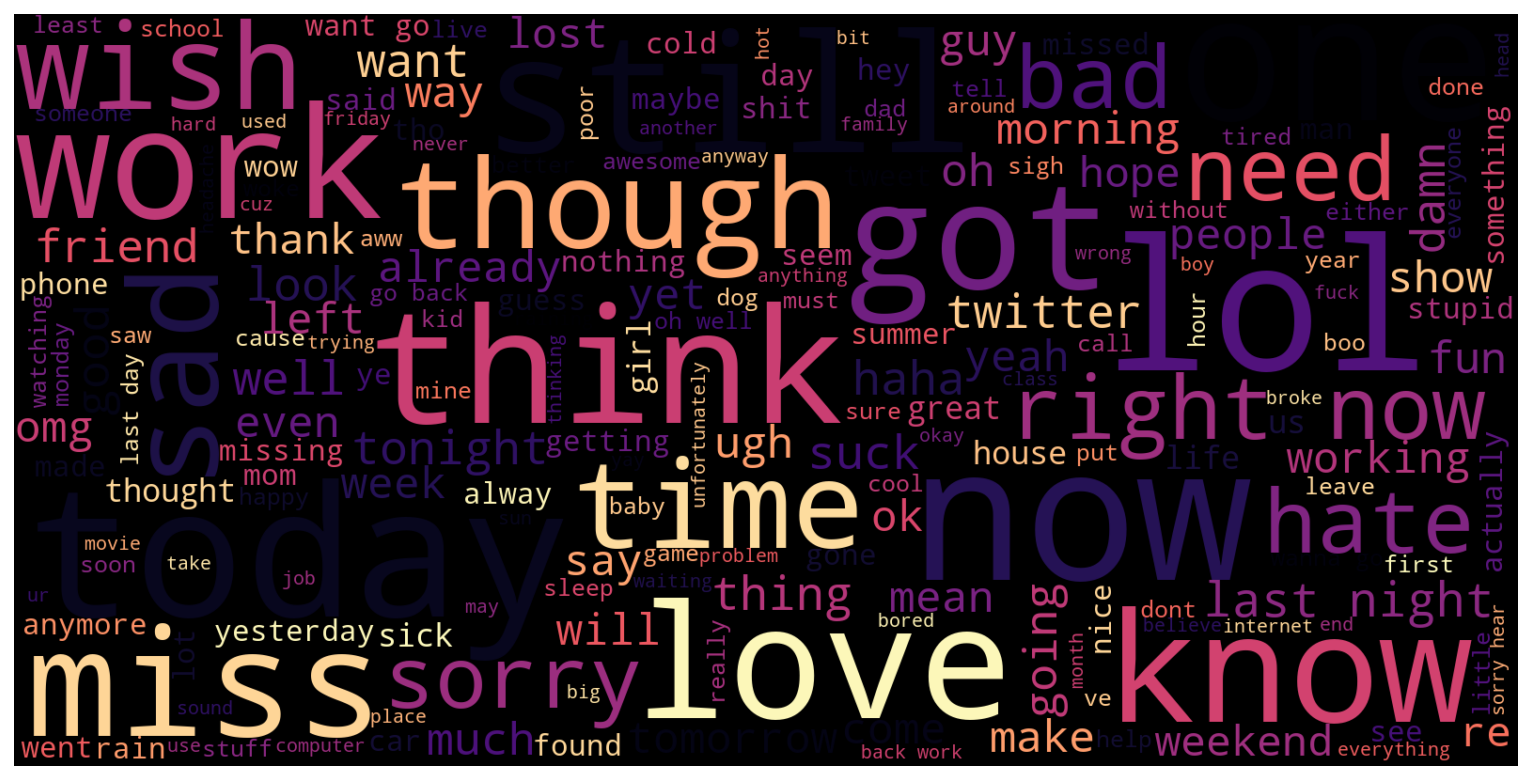

In [0]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [0]:
pos_tweets = df[df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

Word cloud of all positive tweets

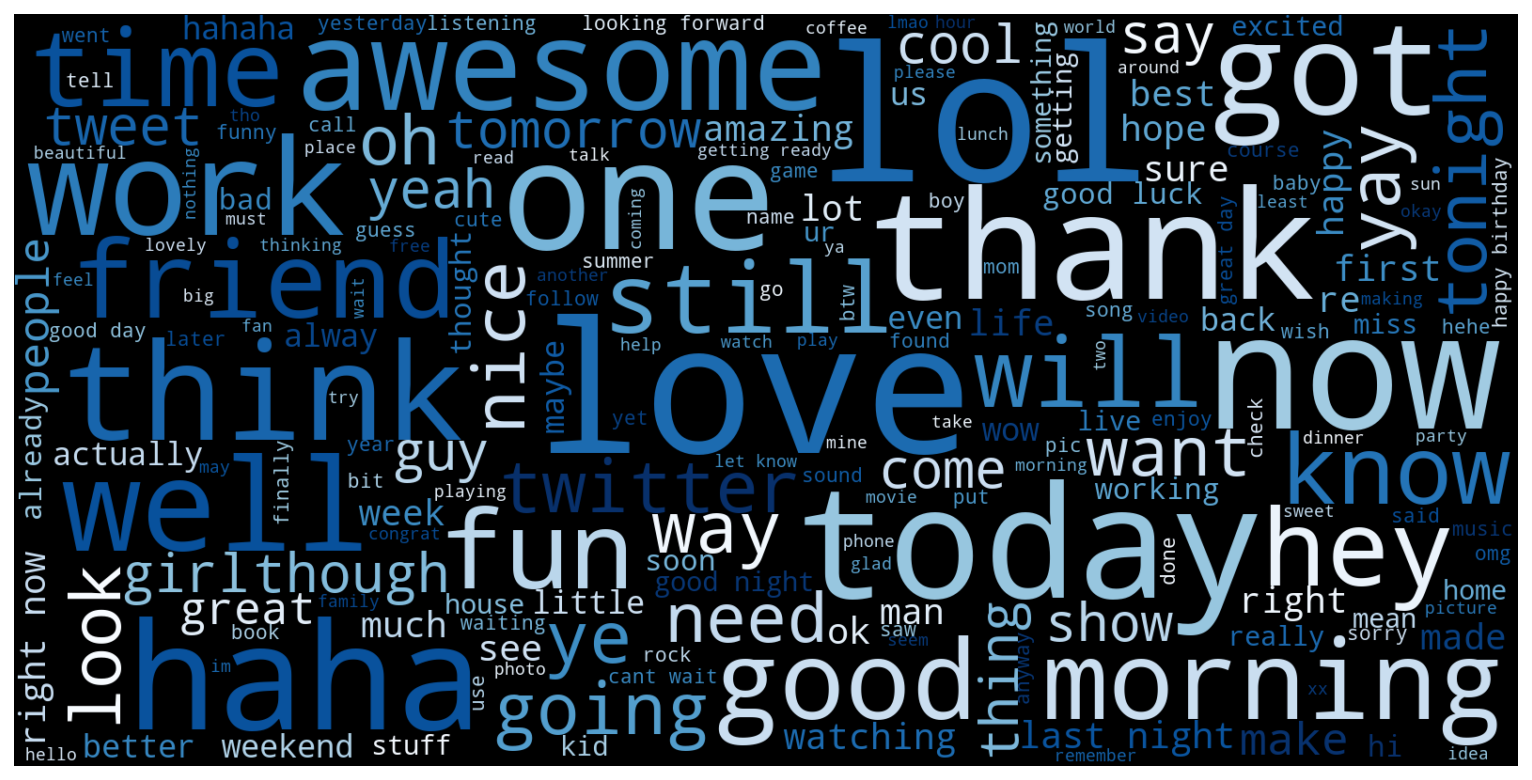

In [0]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='Blues').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Feature Extraction

Note on parameters for vectorization methods

A couple things to note about the parameters for the following document vectorization methods:

*   **max_df**: this is the maximum frequency within the documents a given feature can have to be used in the matrix. If the term is in greater than 80% of the documents it probably carries little meaning (in the context of the article)
*  **min_idf**: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.
*   **ngram_range**: this just means I'll look at unigrams, bigrams and trigrams. See n-grams 

**Alternative Explanation**

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:

*   max_df = 0.50 means "ignore terms that appear in more than 50% of the  documents".
*   max_df = 25 means "ignore terms that appear in more than 25 documents".

The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.

**min_df** is used for removing terms that appear too infrequently. For example:

*   min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
*   min_df = 5 means "ignore terms that appear in less than 5 documents".

The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.


In [0]:
tweets = df.text.tolist()

### Model Training Prep

Train / Dev / Test Split

Given the 1.5 million+ size of the dataset, I will split the data into training, validation, and test data.

In [0]:
x = df.text
y = df.target

In [0]:
SEED = 5000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [0]:
print("Train set has total {0} entries with {1:.2f}% negative tweets, {2:.2f}% positive tweets.".format(len(x_train),
                                                                             (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
                                                                            (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative tweets, {2:.2f}% positive tweets.".format(len(x_validation),
                                                                             (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
                                                                            (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative tweets, {2:.2f}% positive tweets.".format(len(x_test),
                                                                             (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
                                                                            (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564120 entries with 50.02% negative tweets, 49.98% positive tweets.
Validation set has total 15960 entries with 49.18% negative tweets, 50.82% positive tweets.
Test set has total 15961 entries with 49.86% negative tweets, 50.14% positive tweets.


### CountVectorizer

In [0]:
cvector = CountVectorizer()
cvector.fit(tweets)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
len(cvector.get_feature_names())

264939

In [0]:
neg_doc_matrix = cvector.transform(df[df.target == 0].text)
pos_doc_matrix = cvector.transform(df[df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvector.get_feature_names()).transpose()

In [0]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86861,281585
is,133432,111191,244623
in,115542,101160,216702
for,98999,117369,216368


In [0]:
term_freq_df.sort_values(by='total', ascending=False).head(20)

,negative,positive,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86861,281585
is,133432,111191,244623
in,115542,101160,216702
for,98999,117369,216368


Defining functions that iteratively train and calculate accuracy of the model.

In [0]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("f1 score: {0:.2f}%".format(f1*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time #change accuracy to f1 to output f1 score

In [0]:
cvector = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvector, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print((classifier))
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

#### Feature Extraction

##### Unigram Model

**Stopwords Evaluation**

The following code is to evaluate how well the models perform with/without stopwords. The two conditions are the following:
*  no stop words: data does not include any stopwords
*  stop words: data includes all stop words

In [0]:
%%time
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_nostopwords = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.08%
f1 score: 77.95%
model is 26.26% more accurate than null accuracy
train and test time: 42.21s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.74%
f1 score: 78.55%
model is 26.92% more accurate than null accuracy
train and test time: 46.70s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.84%
f1 score: 78.63%
model is 27.02% more accurate than null accuracy
train and test time: 46.79s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.98%
f1 score: 78.78%
model is 27.16% more accurate than null accuracy
train and test time: 47.81s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.81%
f1 score: 78.70%
model is 26.99% more accurate than null accuracy
train and test time: 47.26s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.78%
f1 score: 78.57%
model is 26.95% more accurate than null accuracy
train and test time: 47.76s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.84%
f1 score: 78.61%
model is 27.02% more accurate than null accuracy
train and test time: 48.09s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.85%
f1 score: 78.57%
model is 27.03% more accurate than null accuracy
train and test time: 48.82s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.72%
f1 score: 78.51%
model is 26.90% more accurate than null accuracy
train and test time: 49.56s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 77.92%
f1 score: 78.69%
model is 27.10% more accurate than null accuracy
train and test time: 50.11s
--------------------------------------------------------------------------------
CPU times: user 8min 33s, sys: 3min 25s, total: 11min 58s
Wall time: 7min 55s


In [0]:
%%time
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_stopwords = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.05%
f1 score: 80.72%
model is 29.23% more accurate than null accuracy
train and test time: 47.58s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.30%
f1 score: 80.95%
model is 29.48% more accurate than null accuracy
train and test time: 49.64s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.38%
f1 score: 80.95%
model is 29.56% more accurate than null accuracy
train and test time: 50.85s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.29%
f1 score: 80.88%
model is 29.47% more accurate than null accuracy
train and test time: 50.46s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.30%
f1 score: 80.93%
model is 29.48% more accurate than null accuracy
train and test time: 51.30s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.43%
f1 score: 81.00%
model is 29.61% more accurate than null accuracy
train and test time: 52.44s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.44%
f1 score: 81.02%
model is 29.62% more accurate than null accuracy
train and test time: 54.35s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.53%
f1 score: 81.13%
model is 29.71% more accurate than null accuracy
train and test time: 54.33s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.47%
f1 score: 81.03%
model is 29.65% more accurate than null accuracy
train and test time: 55.22s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.43%
f1 score: 81.01%
model is 29.61% more accurate than null accuracy
train and test time: 56.82s
--------------------------------------------------------------------------------
CPU times: user 9min 23s, sys: 3min 30s, total: 12min 53s
Wall time: 8min 43s


###### Stopwords (Unigram) Accuracy Plot

**matplotlib.legend location options**

Location String + Location Code
*  'best' 	0
*  'upper right' 	1
*  'upper left' 	2
*  'lower left' 	3
*  'lower right' 	4
*  'right' 	5
*  'center left' 	6
*  'center right' 	7
*  'lower center' 	8
*  'upper center' 	9
*  'center' 	10

Plotting stopwords evaluation accuracy results

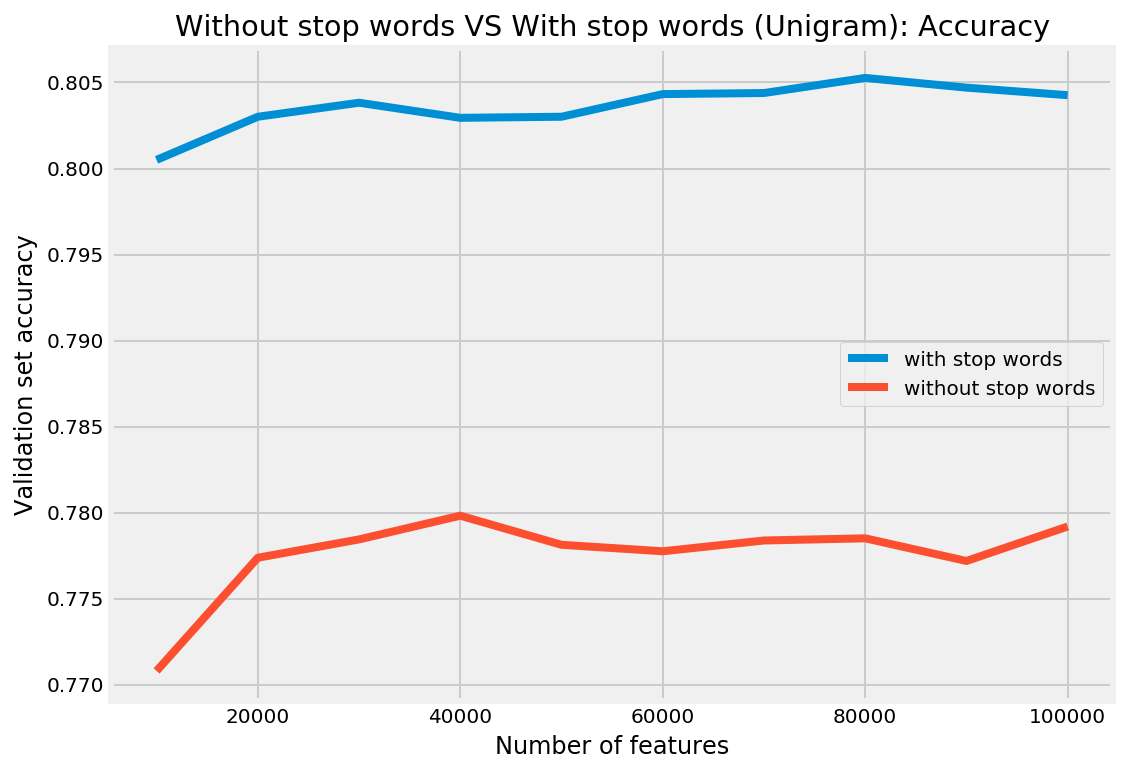

In [0]:
nfeatures_plot_stopwords = pd.DataFrame(feature_result_stopwords,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_nostopwords = pd.DataFrame(feature_result_nostopwords,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_stopwords.nfeatures, nfeatures_plot_stopwords.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_nostopwords.nfeatures, nfeatures_plot_nostopwords.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend(loc = 7)

**Note on stop words**

Based on the unigram model evaluation with and without stop words, it was clear that models that included stop words resulted in significantly higher accuracy. Therefore, moving forward, I will only use models that include stop words.

##### Bigram Model

In [0]:
%%time
print("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bigram = nfeature_accuracy_checker(ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 81.27%
f1 score: 81.97%
model is 30.44% more accurate than null accuracy
train and test time: 95.30s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 81.90%
f1 score: 82.45%
model is 31.08% more accurate than null accuracy
train and test time: 100.30s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.09%
f1 score: 82.65%
model is 31.27% more accurate than null accuracy
train and test time: 99.90s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.43%
f1 score: 82.94%
model is 31.61% more accurate than null accuracy
train and test time: 101.64s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.43%
f1 score: 82.93%
model is 31.61% more accurate than null accuracy
train and test time: 101.51s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.34%
f1 score: 82.85%
model is 31.52% more accurate than null accuracy
train and test time: 104.65s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.29%
f1 score: 82.79%
model is 31.47% more accurate than null accuracy
train and test time: 108.11s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.42%
f1 score: 82.93%
model is 31.60% more accurate than null accuracy
train and test time: 107.37s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.36%
f1 score: 82.83%
model is 31.54% more accurate than null accuracy
train and test time: 106.88s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.49%
f1 score: 82.98%
model is 31.67% more accurate than null accuracy
train and test time: 113.42s
--------------------------------------------------------------------------------
CPU times: user 17min 57s, sys: 3min 39s, total: 21min 36s
Wall time: 17min 19s


##### Trigram Model

In [0]:
%%time
print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_trigram = nfeature_accuracy_checker(ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 81.06%
f1 score: 81.77%
model is 30.24% more accurate than null accuracy
train and test time: 190.62s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 81.93%
f1 score: 82.51%
model is 31.11% more accurate than null accuracy
train and test time: 195.02s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.21%
f1 score: 82.78%
model is 31.39% more accurate than null accuracy
train and test time: 195.26s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.33%
f1 score: 82.87%
model is 31.51% more accurate than null accuracy
train and test time: 199.17s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.54%
f1 score: 83.05%
model is 31.72% more accurate than null accuracy
train and test time: 192.95s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.64%
f1 score: 83.18%
model is 31.82% more accurate than null accuracy
train and test time: 190.80s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.77%
f1 score: 83.26%
model is 31.95% more accurate than null accuracy
train and test time: 192.62s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.66%
f1 score: 83.17%
model is 31.84% more accurate than null accuracy
train and test time: 193.77s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.52%
f1 score: 83.04%
model is 31.70% more accurate than null accuracy
train and test time: 200.70s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.64%
f1 score: 83.18%
model is 31.82% more accurate than null accuracy
train and test time: 198.64s
--------------------------------------------------------------------------------
CPU times: user 32min 52s, sys: 3min 51s, total: 36min 44s
Wall time: 32min 29s


#### Selecting Best Validation Set Accuracy for Each n-gram

Function to take a closer look at best performing number of features with each n-gram model (e.g., unigram, bigram, and trigram). The function reports accuracy, confusion matrix, and classification report.

In [0]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("f1 score: {0:.2f}%".format(f1*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("-"*80)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))

##### Unigram

In [0]:
%%time
unigram_cvector = CountVectorizer(max_features=80000)
unigram_pipeline = Pipeline([
        ('vectorizer', unigram_cvector),
        ('classifier', lr)
    ])
train_test_and_evaluate(unigram_pipeline, x_train, y_train, x_validation, y_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.53%
f1 score: 81.13%
model is 29.71% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6172                1677
positive                1431                6680
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.79      0.80      7849
    positive       0.80      0.82      0.81      8111

    accuracy                           0.81     15960
   macro avg       0.81      0.80      0.81     15960
weighted avg       0.81      0.81      0.81     15960

CPU times: user 59.1 s, sys: 22.2 s, total: 1min 21s
Wall time: 54.9 s


Unigram Accuracy Summary

In [0]:
print('Unigram Accuracy Summary for CountVectorizer')
unigram_cv_accuracy_summary = pd.DataFrame({
    'Method': ['CountVectorizer'],
    'n-gram': ['unigram'],
    'Features': [80000],
    'Accuracy': ['80.53%']
    })
unigram_cv_accuracy_summary

Unigram Accuracy Summary for CountVectorizer


,Method,n-gram,Features,Accuracy
0,CountVectorizer,unigram,80000,80.53%


##### Bigram

In [0]:
%%time
bigram_cvector = CountVectorizer(max_features=100000,ngram_range=(1, 2))
bigram_pipeline = Pipeline([
        ('vectorizer', bigram_cvector),
        ('classifier', lr)
    ])
train_test_and_evaluate(bigram_pipeline, x_train, y_train, x_validation, y_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.49%
f1 score: 82.98%
model is 31.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6356                1493
positive                1301                6810
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.81      0.82      7849
    positive       0.82      0.84      0.83      8111

    accuracy                           0.82     15960
   macro avg       0.83      0.82      0.82     15960
weighted avg       0.83      0.82      0.82     15960

CPU times: user 2min 3s, sys: 23.2 s, total: 2min 26s
Wall time: 1min 58s


Bigram Accuracy Summary

In [0]:
print('Bigram Accuracy Summary for CountVectorizer')
bigram_cv_accuracy_summary = pd.DataFrame({
    'Method': ['CountVectorizer'],    
    'n-gram': ['bigram'],
    'Features': [100000],
    'Accuracy': ['82.49%']
    })
bigram_cv_accuracy_summary

Bigram Accuracy Summary for CountVectorizer


,Method,n-gram,Features,Accuracy
0,CountVectorizer,bigram,100000,82.49%


##### Trigram

In [0]:
%%time
trigram_cvector = CountVectorizer(max_features=70000,ngram_range=(1, 3))
trigram_pipeline = Pipeline([
        ('vectorizer', trigram_cvector),
        ('classifier', lr)
    ])
train_test_and_evaluate(trigram_pipeline, x_train, y_train, x_validation, y_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.77%
f1 score: 83.26%
model is 31.95% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6371                1478
positive                1272                6839
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.81      0.82      7849
    positive       0.82      0.84      0.83      8111

    accuracy                           0.83     15960
   macro avg       0.83      0.83      0.83     15960
weighted avg       0.83      0.83      0.83     15960

CPU times: user 3min 33s, sys: 24.6 s, total: 3min 58s
Wall time: 3min 31s


Trigram Accuracy Summary

In [0]:
print('Trigram Accuracy Summary for CountVectorizer')
trigram_cv_accuracy_summary = pd.DataFrame({
    'Method': ['CountVectorizer'],    
    'n-gram': ['trigram'],
    'Features': [70000],
    'Accuracy': ['82.77%']
    })
trigram_cv_accuracy_summary

Trigram Accuracy Summary for CountVectorizer


,Method,n-gram,Features,Accuracy
0,CountVectorizer,trigram,70000,82.77%


##### n-gram Accuracy Summary for CountVectorizer

In [0]:
ngram_cv_accuracy_summary = pd.concat([unigram_cv_accuracy_summary, bigram_cv_accuracy_summary, trigram_cv_accuracy_summary])
ngram_cv_accuracy_summary

,Method,n-gram,Features,Accuracy
0,CountVectorizer,unigram,80000,80.53%
0,CountVectorizer,bigram,100000,82.49%
0,CountVectorizer,trigram,70000,82.77%


### TF-IDF Vectorizer

#### Feature Extraction

In [0]:
tfidf_vector = TfidfVectorizer()

##### Unigram Model

In [0]:
%%time
print("RESULT FOR UNIGRAM WITH STOP WORDS (TF-IDF)\n")
feature_result_ug_tfidf = nfeature_accuracy_checker(vectorizer=tfidf_vector)

RESULT FOR UNIGRAM WITH STOP WORDS (TF-IDF)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.09%
f1 score: 80.53%
model is 29.27% more accurate than null accuracy
train and test time: 49.15s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.50%
f1 score: 80.96%
model is 29.68% more accurate than null accuracy
train and test time: 53.43s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.66%
f1 score: 81.10%
model is 29.84% more accurate than null accuracy
train and test time: 52.78s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.57%
f1 score: 81.00%
model is 29.75% more accurate than null accuracy
train and test time: 53.70s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.66%
f1 score: 81.13%
model is 29.84% more accurate than null accuracy
train and test time: 55.14s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.67%
f1 score: 81.14%
model is 29.85% more accurate than null accuracy
train and test time: 57.02s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.76%
f1 score: 81.22%
model is 29.94% more accurate than null accuracy
train and test time: 57.18s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.60%
f1 score: 81.06%
model is 29.78% more accurate than null accuracy
train and test time: 59.12s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.60%
f1 score: 81.08%
model is 29.78% more accurate than null accuracy
train and test time: 59.69s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.71%
f1 score: 81.12%
model is 29.89% more accurate than null accuracy
train and test time: 58.57s
--------------------------------------------------------------------------------
CPU times: user 10min, sys: 3min 48s, total: 13min 48s
Wall time: 9min 15s


##### Bigram Model

In [0]:
%%time
print("RESULT FOR BIGRAM WITH STOP WORDS (TF-IDF)\n")
feature_result_bg_tfidf = nfeature_accuracy_checker(vectorizer=tfidf_vector, ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS (TF-IDF)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 81.44%
f1 score: 81.92%
model is 30.62% more accurate than null accuracy
train and test time: 97.50s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.21%
f1 score: 82.60%
model is 31.38% more accurate than null accuracy
train and test time: 105.29s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.28%
f1 score: 82.64%
model is 31.46% more accurate than null accuracy
train and test time: 104.03s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.61%
f1 score: 82.98%
model is 31.79% more accurate than null accuracy
train and test time: 103.42s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.77%
f1 score: 83.12%
model is 31.95% more accurate than null accuracy
train and test time: 103.28s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.76%
f1 score: 83.14%
model is 31.94% more accurate than null accuracy
train and test time: 107.06s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.81%
f1 score: 83.17%
model is 31.99% more accurate than null accuracy
train and test time: 110.89s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.76%
f1 score: 83.10%
model is 31.94% more accurate than null accuracy
train and test time: 113.85s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 83.02%
f1 score: 83.37%
model is 32.20% more accurate than null accuracy
train and test time: 112.12s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.99%
f1 score: 83.35%
model is 32.17% more accurate than null accuracy
train and test time: 112.61s
--------------------------------------------------------------------------------
CPU times: user 18min 33s, sys: 3min 52s, total: 22min 25s
Wall time: 17min 50s


##### Trigram Model

In [0]:
%%time
print("RESULT FOR TRIGRAM WITH STOP WORDS (TF-IDF)\n")
feature_result_tg_tfidf = nfeature_accuracy_checker(vectorizer=tfidf_vector, ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (TF-IDF)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


Validation result for 10000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 81.19%
f1 score: 81.69%
model is 30.37% more accurate than null accuracy
train and test time: 187.91s
--------------------------------------------------------------------------------
Validation result for 20000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.13%
f1 score: 82.52%
model is 31.31% more accurate than null accuracy
train and test time: 192.82s
--------------------------------------------------------------------------------
Validation result for 30000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.38%
f1 score: 82.74%
model is 31.56% more accurate than null accuracy
train and test time: 198.64s
--------------------------------------------------------------------------------
Validation result for 40000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.41%
f1 score: 82.82%
model is 31.59% more accurate than null accuracy
train and test time: 196.07s
--------------------------------------------------------------------------------
Validation result for 50000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 82.75%
f1 score: 83.17%
model is 31.93% more accurate than null accuracy
train and test time: 196.21s
--------------------------------------------------------------------------------
Validation result for 60000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 83.03%
f1 score: 83.39%
model is 32.21% more accurate than null accuracy
train and test time: 199.85s
--------------------------------------------------------------------------------
Validation result for 70000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 83.10%
f1 score: 83.48%
model is 32.27% more accurate than null accuracy
train and test time: 207.11s
--------------------------------------------------------------------------------
Validation result for 80000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 83.22%
f1 score: 83.57%
model is 32.40% more accurate than null accuracy
train and test time: 205.60s
--------------------------------------------------------------------------------
Validation result for 90000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 83.16%
f1 score: 83.48%
model is 32.34% more accurate than null accuracy
train and test time: 212.89s
--------------------------------------------------------------------------------
Validation result for 100000 features


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 83.15%
f1 score: 83.50%
model is 32.32% more accurate than null accuracy
train and test time: 208.25s
--------------------------------------------------------------------------------
CPU times: user 33min 54s, sys: 4min 9s, total: 38min 4s
Wall time: 33min 25s


#### Selecting Best Validation Set Accuracy for Each n-gram

Function to take a closer look at best performing number of features with each n-gram model (e.g., unigram, bigram, and trigram). The function reports accuracy, confusion matrix, and classification report.

##### Unigram

In [0]:
%%time
unigram_tfidf_vector = TfidfVectorizer(max_features=70000)
unigram_pipeline_tfidf = Pipeline([
        ('vectorizer', unigram_tfidf_vector),
        ('classifier', lr)
    ])
train_test_and_evaluate(unigram_pipeline_tfidf, x_train, y_train, x_validation, y_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 80.76%
f1 score: 81.22%
model is 29.94% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6249                1600
positive                1471                6640
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.81      0.80      0.80      7849
    positive       0.81      0.82      0.81      8111

    accuracy                           0.81     15960
   macro avg       0.81      0.81      0.81     15960
weighted avg       0.81      0.81      0.81     15960

CPU times: user 1min 1s, sys: 24.2 s, total: 1min 26s
Wall time: 57.1 s


In [0]:
print('Unigram Accuracy Summary for TfidfVectorizer')
unigram_tfidf_accuracy_summary = pd.DataFrame({
    'Method': ['TF-IDF'],
    'n-gram': ['unigram'],
    'Features': [70000],
    'Accuracy': ['80.76%']
    })
unigram_tfidf_accuracy_summary

Unigram Accuracy Summary for TfidfVectorizer


,Method,n-gram,Features,Accuracy
0,TF-IDF,unigram,70000,80.76%


##### Bigram

In [0]:
%%time
bigram_tfidf_vector = TfidfVectorizer(max_features=90000,ngram_range=(1, 2))
bigram_pipeline_tfidf = Pipeline([
        ('vectorizer', bigram_tfidf_vector),
        ('classifier', lr)
    ])
train_test_and_evaluate(bigram_pipeline_tfidf, x_train, y_train, x_validation, y_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 83.02%
f1 score: 83.37%
model is 32.20% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6458                1391
positive                1319                6792
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.82      0.83      7849
    positive       0.83      0.84      0.83      8111

    accuracy                           0.83     15960
   macro avg       0.83      0.83      0.83     15960
weighted avg       0.83      0.83      0.83     15960

CPU times: user 1min 56s, sys: 25 s, total: 2min 21s
Wall time: 1min 51s


In [0]:
print('Bigram Accuracy Summary for TfidfVectorizer')
bigram_tfidf_accuracy_summary = pd.DataFrame({
    'Method': ['TF-IDF'],
    'n-gram': ['bigram'],
    'Features': [90000],
    'Accuracy': ['83.02%']
    })
bigram_tfidf_accuracy_summary

Bigram Accuracy Summary for TfidfVectorizer


,Method,n-gram,Features,Accuracy
0,TF-IDF,bigram,90000,83.02%


##### Trigram

In [0]:
%%time
trigram_tfidf_vector = TfidfVectorizer(max_features=80000,ngram_range=(1, 3))
trigram_pipeline_tfidf = Pipeline([
        ('vectorizer', trigram_tfidf_vector),
        ('classifier', lr)
    ])
train_test_and_evaluate(trigram_pipeline_tfidf, x_train, y_train, x_validation, y_validation)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 83.22%
f1 score: 83.57%
model is 32.40% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6470                1379
positive                1299                6812
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.83      0.82      0.83      7849
    positive       0.83      0.84      0.84      8111

    accuracy                           0.83     15960
   macro avg       0.83      0.83      0.83     15960
weighted avg       0.83      0.83      0.83     15960

CPU times: user 3min 24s, sys: 26.5 s, total: 3min 51s
Wall time: 3min 21s


In [0]:
print('Trigram Accuracy Summary for TfidfVectorizer')
trigram_tfidf_accuracy_summary = pd.DataFrame({
    'Method': ['TF-IDF'],
    'n-gram': ['trigram'],
    'Features': [80000],
    'Accuracy': ['83.22%']
    })
trigram_tfidf_accuracy_summary

Trigram Accuracy Summary for TfidfVectorizer


,Method,n-gram,Features,Accuracy
0,TF-IDF,trigram,80000,83.22%


##### n-gram Accuracy Summary for TFidfVectorizer

In [0]:
ngram_tfidf_accuracy_summary = pd.concat(
    [unigram_tfidf_accuracy_summary, 
     bigram_tfidf_accuracy_summary, 
     trigram_tfidf_accuracy_summary])
ngram_tfidf_accuracy_summary

,Method,n-gram,Features,Accuracy
0,TF-IDF,unigram,70000,80.76%
0,TF-IDF,bigram,90000,83.02%
0,TF-IDF,trigram,80000,83.22%


### n-gram Best Accuracy Summary (Countvectorizer vs TF-IDF)

Models using trigrams result in the highest accuracy scores:
*  For Countvectorizer, 70,000 features result in 82.77%.
*  For TF-IDF, 80,000 features result in 83.22%.

In [0]:
ngram_cvec_tfidf_accuracy_summary = pd.concat(
    [ngram_cv_accuracy_summary, 
     ngram_tfidf_accuracy_summary])

ngram_cvec_tfidf_accuracy_summary.to_csv('cvec_tfidf_accuracy_summary.csv', index = False)
ngram_cvec_tfidf_accuracy_summary

,Method,n-gram,Features,Accuracy
0,CountVectorizer,unigram,80000,80.53%
0,CountVectorizer,bigram,100000,82.49%
0,CountVectorizer,trigram,70000,82.77%
0,TF-IDF,unigram,70000,80.76%
0,TF-IDF,bigram,90000,83.02%
0,TF-IDF,trigram,80000,83.22%


### Plotting Accuracy Results (Countvectorizer vs TF-IDF)

NOTE: Must run all previous code to generate plot

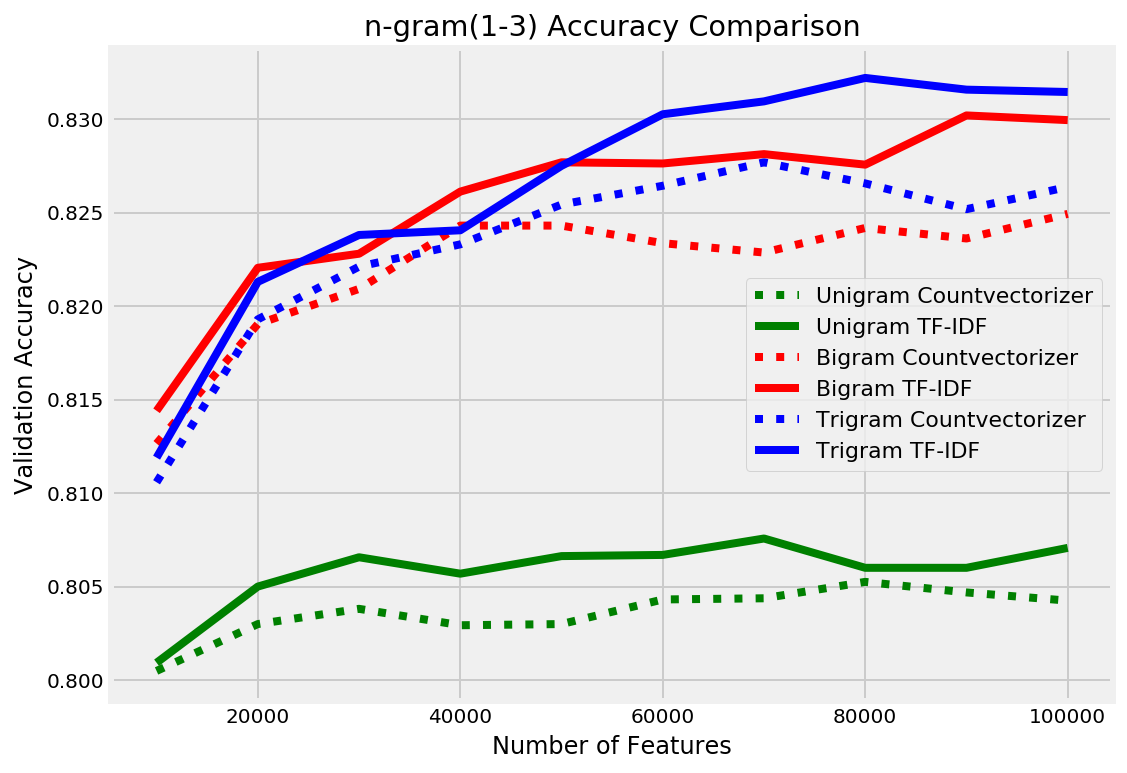

In [0]:
#tfidf results
nfeatures_plot_ug_tfidf = pd.DataFrame(feature_result_ug_tfidf,
                                  columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bg_tfidf = pd.DataFrame(feature_result_bg_tfidf,
                                  columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tg_tfidf = pd.DataFrame(feature_result_tg_tfidf,
                                  columns=['nfeatures','validation_accuracy','train_test_time'])

#countvectorization results
nfeatures_plot_bg = pd.DataFrame(feature_result_bigram,
                                  columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_tg = pd.DataFrame(feature_result_trigram,
                                  columns=['nfeatures','validation_accuracy','train_test_time'])


plt.figure(figsize=(8,6))

plt.plot(nfeatures_plot_stopwords.nfeatures, nfeatures_plot_stopwords.validation_accuracy, label='Unigram Countvectorizer',linestyle=':',color='green')
plt.plot(nfeatures_plot_ug_tfidf.nfeatures, nfeatures_plot_ug_tfidf.validation_accuracy, label='Unigram TF-IDF',color='green')

plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='Bigram Countvectorizer',linestyle=':',color='red')
plt.plot(nfeatures_plot_bg_tfidf.nfeatures, nfeatures_plot_bg_tfidf.validation_accuracy,label='Bigram TF-IDF',color='red')

plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='Trigram Countvectorizer',linestyle=':', color='blue')
plt.plot(nfeatures_plot_tg_tfidf.nfeatures, nfeatures_plot_tg_tfidf.validation_accuracy,label='Trigram TF-IDF',color='blue')

plt.title("n-gram(1-3) Accuracy Comparison")
plt.xlabel("Number of Features")
plt.ylabel("Validation Accuracy")
plt.legend(fontsize = 11, loc = 'center right')
plt.savefig('ngram_accuracy_comparison_plot.png')

### Comparing with Alternative Classifers

In [0]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import NearestCentroid

In [0]:
names = ["Logistic Regression", "Linear SVC", "Multinomial NB", "Ridge Classifier", "Nearest Centroid"]
classifiers = [
    LogisticRegression(),
    LinearSVC(),
    MultinomialNB(),
    RidgeClassifier(),
    NearestCentroid()
    ]
zipped_clf = zip(names,classifiers)

In [0]:
tfidf_vector = TfidfVectorizer()

def classifier_compare(vectorizer=tfidf_vector, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result

Using 80000 features for the classifier comparison since the logistic regression model using a trigram TF-IDF vectorizer yielded the best results.

In [0]:
%%time
classifier_compare_trigram = classifier_compare(n_features=80000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


null accuracy: 50.82%
accuracy score: 83.22%
f1 score: 83.57%
model is 32.40% more accurate than null accuracy
train and test time: 203.43s
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
null accuracy: 50.82%
accuracy score: 82.82%
f1 score: 83.22%
model is 32.00% more accurate than null accuracy
train and test time: 207.90s
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
null accuracy: 50.82%
accuracy score: 80.76%
f1 score: 80.87%
model is 29.94% more accurate than null accuracy
train and test time: 173.74s
-----------------------------------------------------------

#### Classifier Comparison Results Summary

In [6]:
print('Classifier Comparison Accuracy Summmary')
clf_compare_accuracy_summary = pd.DataFrame({
    'Classifier': ['Logistic Regression', 
                   'Linear SVC',
                   'MultinomialNB',
                   'Ridge Classifier',
                   'Nearest Centroid'],
    'Val Accuracy': ['83.22%', 
                 '82.82%',
                 '80.76%',
                 '82.65%',
                 '72.70%']
    })

clf_compare_accuracy_summary.to_csv('clf_compare_accuracy_summary.csv', index = False)
clf_compare_accuracy_summary

Classifier Comparison Accuracy Summmary


,Classifier,Val Accuracy
0,Logistic Regression,83.22%
1,Linear SVC,82.82%
2,MultinomialNB,80.76%
3,Ridge Classifier,82.65%
4,Nearest Centroid,72.70%


### Doc2vec

I will be using two models for Doc2vec:
*  Distributed Bag Of Words (PV-DBOW)
*  Distributed Memory Mean (PV-DM)

For both models, not the following parameters:
*  **dm** ({1,0}, optional) – Defines the training algorithm. If dm=1, ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.
*  **dbow_words** ({1,0}, optional) – If set to 1 trains word-vectors (in skip-gram fashion) simultaneous with DBOW doc-vector training; If 0, only trains doc-vectors (faster).
*  **vector_size** (int, optional) – Dimensionality of the feature vectors.
*  **min_count** (int, optional) – Ignores all words with total frequency lower than this.
*  **negative** (int, optional) – If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
*  **dm_mean** ({1,0}, optional) – If 0 , use the sum of the context word vectors. If 1, use the mean. Only applies when dm is used in non-concatenative mode.
*  **workers** (int, optional) – Use these many worker threads to train the model (=faster training with multicore machines).
*  **alpha** (float, optional) – The initial learning rate.
*  **min_alpha** (float, optional) – Learning rate will linearly drop to min_alpha as training progresses.

For more info on Doc2vec, see https://radimrehurek.com/gensim/models/doc2vec.html

Import relevant libraries/packages

In [0]:
from tqdm import tqdm, tqdm_notebook
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence, TaggedDocument
import multiprocessing
from sklearn import utils

In [0]:
cores = multiprocessing.cpu_count()
cores

2

In [0]:
def tag_tweets(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [0]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = tag_tweets(all_x, 'all')

#### DBOW (Distribued Bag of Words)

In [0]:
%%time
model_dbow = Doc2Vec(dm=0, 
                     dbow_words=0, 
                     vector_size=100, 
                     negative=5, 
                     min_count=2, 
                     workers=cores, 
                     alpha=0.065, 
                     min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm_notebook(all_x_w2v)])


CPU times: user 5min 41s, sys: 2.99 s, total: 5min 44s
Wall time: 5min 44s


In [0]:
%%time
for epoch in range(15):
    model_dbow.train(utils.shuffle([x for x in tqdm_notebook(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


CPU times: user 36min 25s, sys: 4min 18s, total: 40min 43s
Wall time: 30min 23s


In [0]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i in corpus.index:
        prefix = 'all_' + str(i)
        vecs[n] = model.docvecs[prefix]
        n += 1
    return vecs

In [0]:
model_dbow.save('d2v_model_dbow.doc2vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Define Vectors

In [0]:
train_vecs_dbow = get_vectors(model_dbow, x_train, 100)
validation_vecs_dbow = get_vectors(model_dbow, x_validation, 100)

In [0]:
lr_clf = LogisticRegression()
lr_clf.fit(train_vecs_dbow, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_clf.score(validation_vecs_dbow, y_validation)

0.7387844611528822

##### Accuracy Summary

In [0]:
print('DBOW Accuracy Summary:')
dbow_accuracy_summary = pd.DataFrame({
    'Method': ['d2v-DBOW'],
    'n-gram': ['unigram'],
    'Features': ['100 (size)'],
    'Accuracy': ['73.88%']
    })
dbow_accuracy_summary

DBOW Accuracy Summary:


,Method,n-gram,Features,Accuracy
0,d2v-DBOW,unigram,100 (size),73.88%


In [0]:
dbow_cvec_tfidf_accuracy_summary = pd.concat(
    [ngram_cvec_tfidf_accuracy_summary, 
     dbow_accuracy_summary])

dbow_cvec_tfidf_accuracy_summary.to_csv('dbow_cvec_tfidf_accuracy_summary.csv', index = False)
dbow_cvec_tfidf_accuracy_summary

,Method,n-gram,Features,Accuracy
0,CountVectorizer,unigram,80000,80.53%
0,CountVectorizer,bigram,100000,82.49%
0,CountVectorizer,trigram,70000,82.77%
0,TF-IDF,unigram,70000,80.76%
0,TF-IDF,bigram,90000,83.02%
0,TF-IDF,trigram,80000,83.22%
0,d2v-DBOW,unigram,100 (size),73.88%


#### DMM (Distributed Memory Mean)

In [0]:
model_dmm = Doc2Vec(dm=1, 
                    dm_mean=1, 
                    vector_size=100, 
                    window=4, 
                    negative=5, 
                    min_count=2, 
                    workers=cores, 
                    alpha=0.065, 
                    min_alpha=0.065)

model_dmm.build_vocab([x for x in tqdm_notebook(all_x_w2v)])

In [0]:
%%time
for epoch in range(15):
    model_dmm.train(utils.shuffle([x for x in tqdm_notebook(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha


CPU times: user 1h 4min 18s, sys: 6min 20s, total: 1h 10min 38s
Wall time: 52min 59s


Testing model on common sentiment terms

In [0]:
model_dmm.most_similar('good')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('gooooood', 0.6428312659263611),
 ('goood', 0.6207214593887329),
 ('goooood', 0.609133243560791),
 ('bad', 0.5855158567428589),
 ('gud', 0.5699256062507629),
 ('shitty', 0.5589931607246399),
 ('tough', 0.5475826859474182),
 ('great', 0.5176217555999756),
 ('terrible', 0.4991101324558258),
 ('gd', 0.49181509017944336)]

In [0]:
model_dmm.most_similar('bad')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('terrible', 0.5983003377914429),
 ('good', 0.5855158567428589),
 ('shitty', 0.566300094127655),
 ('booish', 0.5584462881088257),
 ('crappy', 0.5502926707267761),
 ('horrible', 0.5446617007255554),
 ('special', 0.541028618812561),
 ('sad', 0.5407029390335083),
 ('miserable', 0.5254420638084412),
 ('busy', 0.5178250670433044)]

In [0]:
model_dmm.most_similar('happy')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pleased', 0.6182113885879517),
 ('thrilled', 0.5764498710632324),
 ('sad', 0.5441059470176697),
 ('disappointed', 0.5408899784088135),
 ('upset', 0.5369249582290649),
 ('happier', 0.5120342969894409),
 ('gutted', 0.5066630244255066),
 ('suprised', 0.49705833196640015),
 ('happpy', 0.4920858144760132),
 ('happppy', 0.4920620322227478)]

In [0]:
model_dmm.most_similar('angry')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('confused', 0.6109796762466431),
 ('annoyed', 0.596005916595459),
 ('upset', 0.5880251526832581),
 ('mad', 0.5758584141731262),
 ('cranky', 0.56082683801651),
 ('nervous', 0.5579307079315186),
 ('emotional', 0.554975152015686),
 ('drunk', 0.5493310689926147),
 ('drunkk', 0.5481269359588623),
 ('pissed', 0.5380815863609314)]

Define Vectors

In [0]:
train_vecs_dmm = get_vectors(model_dmm, x_train, 100)
validation_vecs_dmm = get_vectors(model_dmm, x_validation, 100)

In [0]:
lr_clf = LogisticRegression()
lr_clf.fit(train_vecs_dmm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
lr_clf.score(validation_vecs_dmm, y_validation)

0.72531328320802

##### Accuracy Summary

In [0]:
print('DMM Accuracy Summary:')
dmm_accuracy_summary = pd.DataFrame({
    'Method': ['d2v-DMM'],
    'n-gram': ['unigram'],
    'Features': ['100 (size)'],
    'Accuracy': ['72.53%']
    })
dmm_accuracy_summary

DMM Accuracy Summary:


,Method,n-gram,Features,Accuracy
0,d2v-DMM,unigram,100 (size),72.53%


### Combined Accuracy Summary

In [0]:
dmm_dbow_cvec_tfidf_accuracy_summary = pd.concat(
    [dbow_cvec_tfidf_accuracy_summary, 
     dmm_accuracy_summary])

dmm_dbow_cvec_tfidf_accuracy_summary.to_csv('dmm_dbow_cvec_tfidf_accuracy_summary.csv', index = False)
dmm_dbow_cvec_tfidf_accuracy_summary

,Method,n-gram,Features,Accuracy
0,CountVectorizer,unigram,80000,80.53%
0,CountVectorizer,bigram,100000,82.49%
0,CountVectorizer,trigram,70000,82.77%
0,TF-IDF,unigram,70000,80.76%
0,TF-IDF,bigram,90000,83.02%
0,TF-IDF,trigram,80000,83.22%
0,d2v-DBOW,unigram,100 (size),73.88%
0,d2v-DMM,unigram,100 (size),72.53%
